# Tutorial 2 - Classification

After working with a regression example in the first tutorial, we proceed with a classification example in this one.

In [1]:
from jaxkan.models.KAN import KAN

import jax
import jax.numpy as jnp

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

## Data Generation

We will use the `make_classification` method of `sklearn.datasets` to generate some mock data for the classification problem.

In [2]:
# Generate synthetic data
seed = 42

X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.5,
    random_state=seed
)

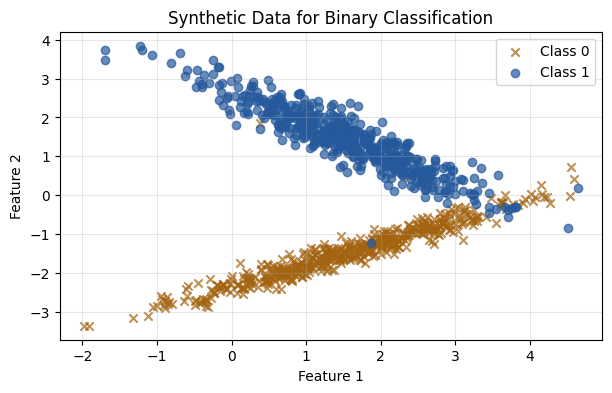

In [3]:
# Plot the generated data
plt.figure(figsize=(7, 4))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 0', alpha=0.7, marker='x', color='#a3630f')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 1', alpha=0.7, marker='o', color='#25599c')
plt.title("Synthetic Data for Binary Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Preprocessing

We split the data in train/test sets.

In [4]:
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (800, 2)
Test set size: (200, 2)


## KAN Model

We covered KAN Model selection in the first tutorial, so feel free to refer to it for more info. For this example, we will be using a Fourier KAN Layer.

In [5]:
# Initialize a KAN model
n_in = X_train.shape[1]
n_out = y_train.shape[1]
n_hidden = 6

layer_dims = [n_in, n_hidden, n_hidden, n_out]
req_params = {'D': 10}

model = KAN(layer_dims = layer_dims,
            layer_type = 'fourier',
            required_parameters = req_params,
            seed = seed
           )

print(model)

KAN( # Param: 1,093 (4.4 KB)
  layer_type='fourier',
  layers=[FourierLayer( # Param: 246 (984 B)
    n_in=2,
    n_out=6,
    D=10,
    bias=Param( # 6 (24 B)
      value=Array(shape=(6,), dtype=dtype('float32'))
    ),
    c_cos=Param( # 120 (480 B)
      value=Array(shape=(6, 2, 10), dtype=dtype('float32'))
    ),
    c_sin=Param( # 120 (480 B)
      value=Array(shape=(6, 2, 10), dtype=dtype('float32'))
    )
  ), FourierLayer( # Param: 726 (2.9 KB)
    n_in=6,
    n_out=6,
    D=10,
    bias=Param( # 6 (24 B)
      value=Array(shape=(6,), dtype=dtype('float32'))
    ),
    c_cos=Param( # 360 (1.4 KB)
      value=Array(shape=(6, 6, 10), dtype=dtype('float32'))
    ),
    c_sin=Param( # 360 (1.4 KB)
      value=Array(shape=(6, 6, 10), dtype=dtype('float32'))
    )
  ), FourierLayer( # Param: 121 (484 B)
    n_in=6,
    n_out=1,
    D=10,
    bias=Param( # 1 (4 B)
      value=Array([0.], dtype=float32)
    ),
    c_cos=Param( # 60 (240 B)
      value=Array(shape=(1, 6, 10), dtype=dtyp

## Training

In [6]:
opt_type = optax.adam(learning_rate=0.001)

optimizer = nnx.Optimizer(model, opt_type)

In this case, the loss function is modified to correspond to a cross entropy loss term.

In [7]:
# Define train loop
@nnx.jit
def train_step(model, optimizer, X_train, y_train):

    def loss_fn(model):

        logits = model(X_train)
        probs = nnx.sigmoid(logits)
        loss = jnp.mean(-y_train * jnp.log(probs + 1e-8) - (1 - y_train) * jnp.log(1 - probs + 1e-8))

        return loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    
    return loss

In [8]:
# Initialize train_losses
num_epochs = 2000
train_losses = jnp.zeros((num_epochs,))

for epoch in range(num_epochs):
    # Calculate the loss
    loss = train_step(model, optimizer, X_train, y_train)
    
    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

2025-11-23 10:45:28.087853: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


## Evaluation

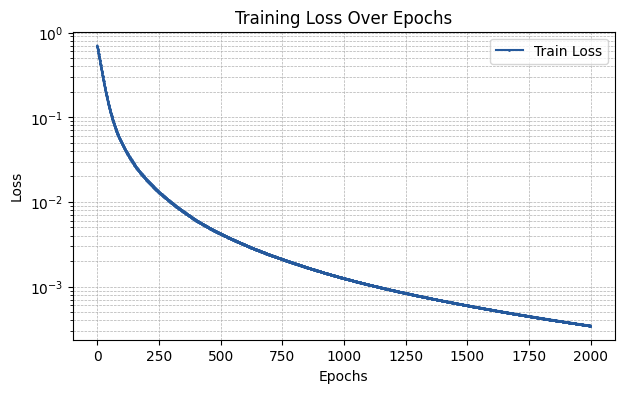

In [9]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

Now the model is evaluated in terms of its F1-Score.

In [10]:
logits = model(X_test)
y_pred = np.array((nnx.sigmoid(logits) > 0.5).astype(int))
score = f1_score(y_pred, y_test)

print(f"The F1-Score of the fit is {100*score:.3f}%")

The F1-Score of the fit is 93.750%
